In [20]:
import json
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, SubsetRandomSampler
from torchvision import models
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import time
import albumentations as A
from collections import Counter

weather_dict_file = open('weather_dict.json','r')
weather_dict = json.load(weather_dict_file)
w_by_i = {int(i):key for i,key in weather_dict[0].items()}
i_by_w = {key:int(i) for key,i in weather_dict[1].items()}
train_folder = 'drivedata_v2/train'
test_folder = 'drivedata_v2/test_weather/'
my_ph_folder = 'my_ph/'
print(w_by_i)
if torch.cuda.is_available():
    device = torch.device('cuda:0')
print(torch.cuda.get_device_name(0))
#i_by_w['partly cloudy'] = 0
print(i_by_w)

{0: 'clear', 1: 'overcast', 2: 'rainy', 3: 'snowy', 4: 'foggy'}
GeForce RTX 2060
{'clear': 0, 'overcast': 1, 'rainy': 2, 'snowy': 3, 'foggy': 4}


In [5]:
def init_aug():
    augmentation_pipeline = A.Compose(
    [
        A.ShiftScaleRotate(rotate_limit=10),
        A.HorizontalFlip(p = 0.5), # apply horizontal flip to 50% of images
        A.OneOf(
            [
                # apply one of transforms to 50% of images
                A.RandomContrast(), # apply random contrast
                A.RandomGamma(), # apply random gamma
                A.RandomBrightness(), # apply random brightness
            ],
            p = 0.5
        ),
    ],
    p = 1
    )
    return augmentation_pipeline

In [13]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        start = time.time()
        for i_step, (x, y,_) in enumerate(train_loader):
            start = time.time()
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value
            print(i_step,  time.time()- start)
        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val balanced accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    pred = list()
    gr_tr = list()
    for (x,y,_) in loader:
        x = x.to(device=device)
        y = y.to(device=device)
        predict = model(x)
        x.cpu()
        _, indices = torch.max(predict, 1)
        gr_tr.extend(y.cpu().tolist())
        pred.extend(indices.cpu().tolist())
        
    val_accuracy = [gr_tr, pred]
    return val_accuracy

In [ ]:
class WeatherDataset(Dataset):
    def __init__(self, folder, transform=None, augmentation=None):
        self.transform = transform
        self.augmentation=augmentation
        self.folder = folder
        filenames = os.listdir(self.folder)
        self.filenames = [name for name in filenames if name != 'desktop.ini' and name.split('_')[2]!='undefined.jpg']
        splited = [x.replace('.jpg','').split('_') for x in self.filenames]
        self.splited = [[i_by_w[x[2]],x[0]] for x in splited]
        self.transform = transform
        
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, index):
        img = Image.open(os.path.join(self.folder, self.filenames[index]))
        y = self.splited[index][0]
        img_id = self.splited[index][1]
        if self.augmentation:
            img = self.augmentation(image = np.array(img))['image']
        if self.transform: 
            img = self.transform(img)
        return img, y, self.filenames[index]

In [ ]:
train_dataset = WeatherDataset(train_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ]),
                        augmentation=init_aug()
                      )
test_dataset =WeatherDataset(test_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )


In [ ]:
batch_size = 16
data_size = len(train_dataset)
validation_fraction = .1
val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)
val_indices, train_indices = indices[:val_split], indices[val_split:]
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=train_sampler,pin_memory=True,num_workers=4)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         sampler=val_sampler,pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,pin_memory=True)
my_ph_loader = torch.utils.data.DataLoader(my_ph_dataset, batch_size=batch_size,pin_memory=True)


In [ ]:
model = torch.load('weather_models_checkpoint/scene_2020-02-24_06-26_4_0.8801598084308191.pt')
model.to(device)

In [37]:
result_file = open('val_result_weather.json','r')
result = json.load(result_file)
pred = np.array(result[0])
gr_tr = np.array(result[1])
print(Counter(pred))

Counter({0: 4787, 1: 1406, 3: 692, 2: 491, 5: 401, 4: 11})


In [38]:
print(metrics.classification_report(gr_tr,pred,target_names=list(i_by_w.keys())))

               precision    recall  f1-score   support

        clear       0.91      0.93      0.92      4669
     overcast       0.70      0.87      0.78      1133
        rainy       0.79      0.66      0.72       594
        snowy       0.81      0.76      0.79       740
        foggy       0.36      0.13      0.20        30
partly cloudy       0.77      0.50      0.61       622

     accuracy                           0.85      7788
    macro avg       0.73      0.64      0.67      7788
 weighted avg       0.85      0.85      0.84      7788



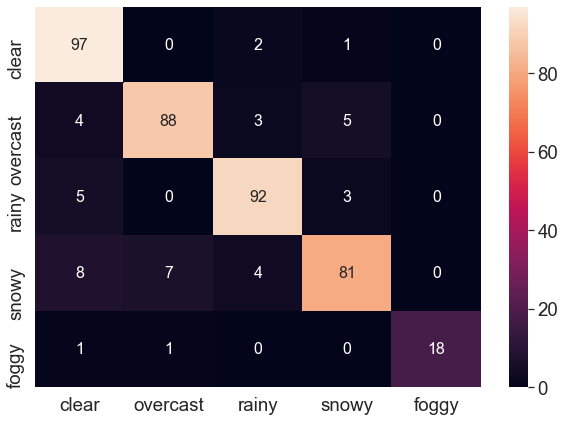

In [18]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = metrics.confusion_matrix(gr_tr,pred)

df_cm = pd.DataFrame(array, i_by_w.keys(), i_by_w.keys())
plt.figure(figsize=(10,7))
sn.set(font_scale=1.7) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

In [51]:
[gr_tr,pred] = compute_accuracy(model,test_loader)
#errors = compute_test_metrics(model, test_loader)

In [52]:
print(metrics.classification_report(gr_tr,pred,target_names=list(i_by_w.keys())))

              precision    recall  f1-score   support

       clear       0.84      0.97      0.90       100
    overcast       0.92      0.88      0.90       100
       rainy       0.91      0.92      0.92       100
       snowy       0.90      0.81      0.85       100
       foggy       1.00      0.90      0.95        20

    accuracy                           0.90       420
   macro avg       0.91      0.90      0.90       420
weighted avg       0.90      0.90      0.89       420



In [32]:
def compute_test_metrics(model,loader):
    model.eval() # Evaluation mode
    pred = list()
    gr_tr = list()
    images = []
    errors = []
    toPILL = transforms.ToPILImage()
    for (x,y,name) in loader:
        x = x.to(device=device)
        y = y.to(device=device)
        predict = model(x)
        _, indices = torch.max(predict, 1)
        y = y.cpu().tolist()
        indices = indices.cpu().tolist()
        gr_tr.extend(y)
        pred.extend(indices)
        errors_temp = [{'image':name[i],'gr_tr':w_by_i[y[i]],"pred":w_by_i[indices[i]]} for i in range(len(y)) if y[i]!=indices[i]]
        errors.extend(errors_temp)
    return errors

In [50]:
folder = 'drivedata_v2/test_weather/'
count = len(errors)
i = 0
for error in errors:
    i+=1
    img = Image.open(os.path.join(folder,error['image']))
    print('gr_tr: %s pred: %s'% (error['gr_tr'],error['pred']), end="\r")
    img.show()
    input()

gr_tr: snowy pred: clear
gr_tr: overcast pred: snowy
